In [115]:
#!pip install pytorch-lightning
#!pip install --upgrade pip && pip3 install h5py=='2.9.0'

In [139]:
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import tqdm 


In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
df = pd.read_csv('Full_Sim_1M.csv')
df_neutrons = df[df[' pdg'].isin([2112])]
df_photons  = df[df[' pdg'].isin([22])]

In [119]:
param_list = [" xx"," yy"," pxx"," pyy"," pzz"," eneg"," time"," pdg"]

df_N = df_neutrons.loc[:,param_list]
df_P = df_photons.loc[:,param_list]
torch_tensor = torch.tensor(df_N[param_list].values)

N_data = TensorDataset(torch_tensor,torch.ones(len(torch_tensor)))


In [199]:
def plot_correlations(x,y,bins=[200,200],loglog=False,Xlim=None,Ylim=None):
  H,xb,yb = np.histogram2d(x,y,bins=bins,range=[[x.min(), x.max()], [y.min(), y.max()]])
  X , Y = np.meshgrid(xb,yb)
  plt.pcolormesh(X,Y,np.log10(H.T))
  if loglog:
    plt.xscale('log')
    plt.yscale('log')
  if Xlim!=None:
      plt.xlim(Xlim)
  if Ylim!=None:
      plt.ylim(Ylim)
  plt.colorbar()
  plt.show()


In [215]:
def plots(df):
  plot_correlations(df[' xx'],df[' yy'],Xlim=[-75000,25000],Ylim=[-50000,5000])
  Ebin = 10**np.linspace(np.log10(df[' eneg'].min()), np.log10(df[' eneg'].max()),200)
  Tbin = 10**np.linspace(np.log10(df[' time'].min()), np.log10(df[' time'].max()),200)
  plot_correlations(df[' time'],df[' eneg'] ,bins = [Tbin,Ebin], loglog=True)
  plot_correlations(df['r'],df['theta'],Xlim=[0,100000])

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/45613613.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


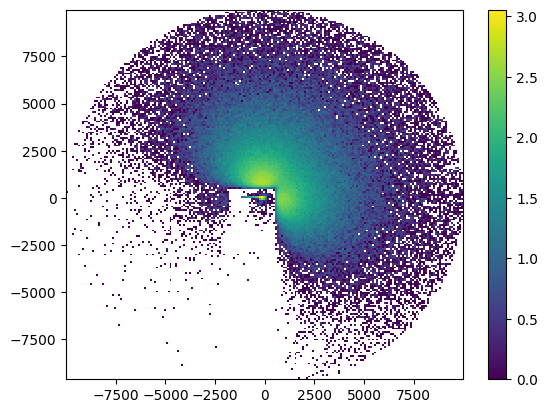

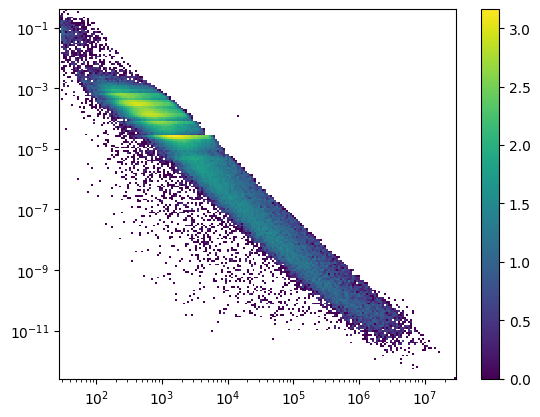

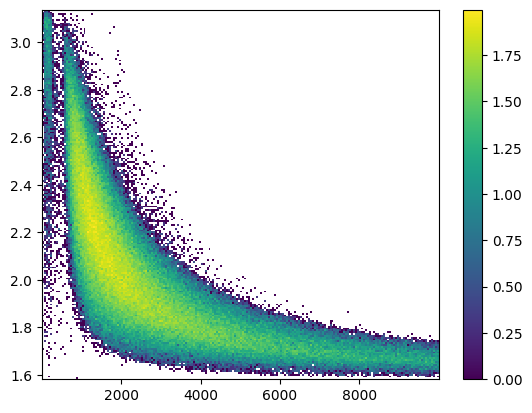

(230247, 10)


In [122]:
df_P['r'] = np.sqrt(df_P[' xx'].values**2 + df_P[' yy'].values**2)
df_N['r'] = np.sqrt(df_N[' xx'].values**2 + df_N[' yy'].values**2)
th_P = np.arccos(df_P[' pzz'].values/np.sqrt(df_P[' pxx'].values**2+df_P[' pyy'].values**2+df_P[' pzz'].values**2))
th_N = np.arccos(df_N[' pzz'].values/np.sqrt(df_N[' pxx'].values**2+df_N[' pyy'].values**2+df_N[' pzz'].values**2))
df_P['theta']=th_P
df_N['theta']=th_N
plots(df_N)
print(df_N.shape)

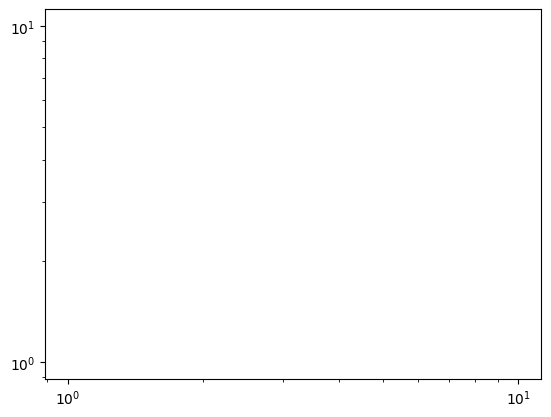

In [124]:
N_T = torch.tensor(df_N.values)
P_T = torch.tensor(df_P.values)
l = [0,1,2,3,4,5,6,8,9]
N_T = N_T[:,l]
P_T = P_T[:,l]
# x , y , p , E , t , pdg , r , theta
P_T.shape
plt.loglog()
plt.show()

In [125]:
def weights_init(m):
    if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight.data, 0.01,0.02)
        print('initialized')

In [174]:
class ParticleDataset(Dataset):
  def __init__(self, data_path, norm_path):
    super().__init__()
    self.data = pd.read_csv(data_path)
    self.data = self.data[self.data[' pdg'].isin([2112])]  # 22 - photons , 2112 - neutrons
    self.data = self.data[[" xx"," yy"," pxx"," pyy"," pzz"," eneg"," time"]]
    # self.data['r'] = np.sqrt(self.data[' xx'].values**2 + self.data[' yy'].values**2)
    # self.data['theta'] = np.arccos(self.data[' pzz'].values/np.sqrt(self.data[' pxx'].values**2+self.data[' pyy'].values**2+self.data[' pzz'].values**2))
    self.norm = pd.read_csv(norm_path, index_col=0)
    for col in self.norm.index:
        self.data[col] = (self.data[col] - self.norm['min'][col]+10**(-5))/(self.norm['max_min_diff'][col]+2*10**(-5))
    self.data = np.sqrt(2)*sp.erfinv(2*(1-self.data.values)-1)
    self.data = self.data.astype(np.float32)
  def __getitem__(self, item):
    return self.data[item, :]
  def __len__(self):
    return self.data.shape[0]

In [175]:
dataset = ParticleDataset('Full_Sim_1M.csv', 'Full_Sim_1M_stats.csv')
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

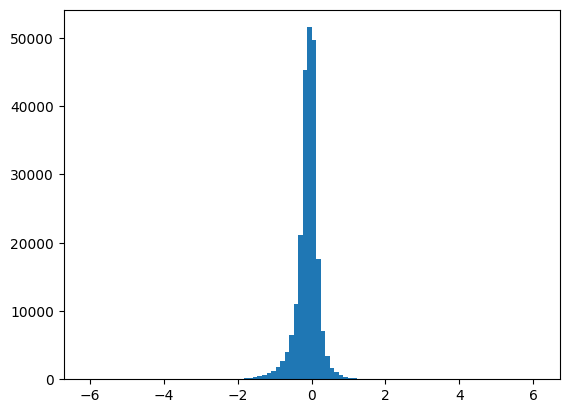

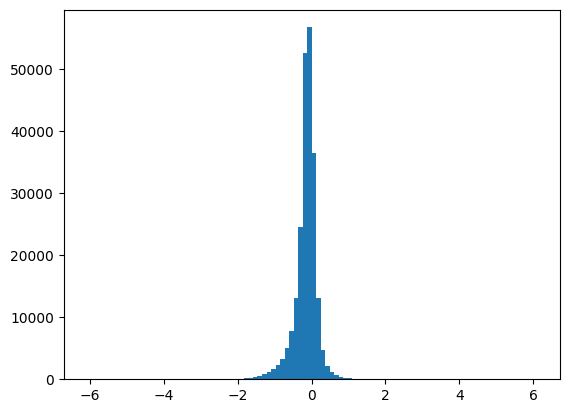

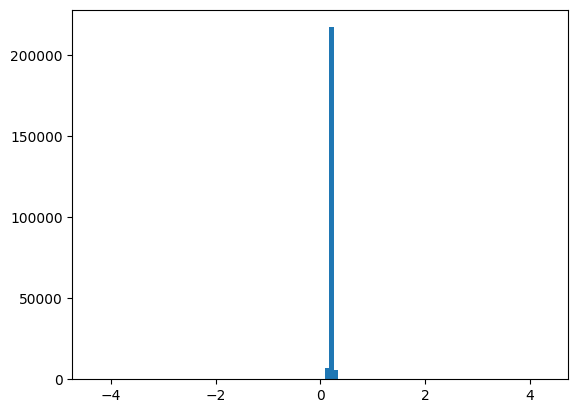

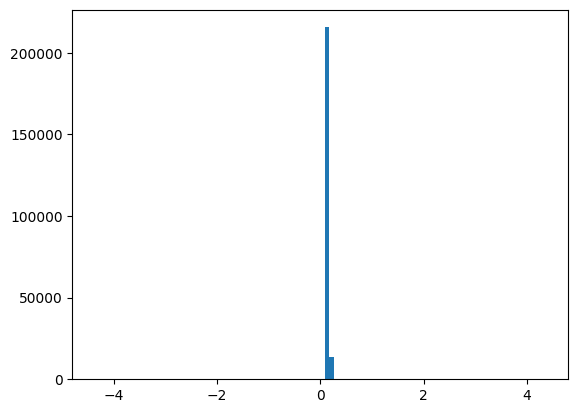

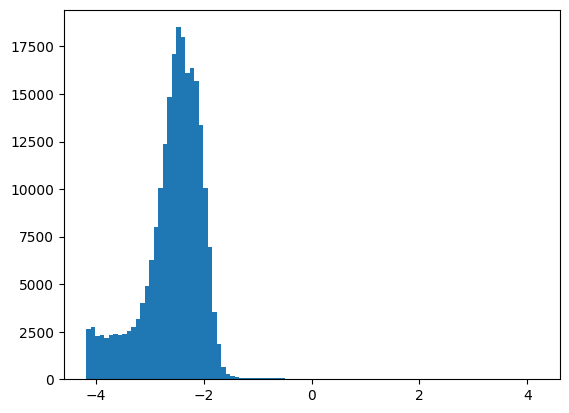

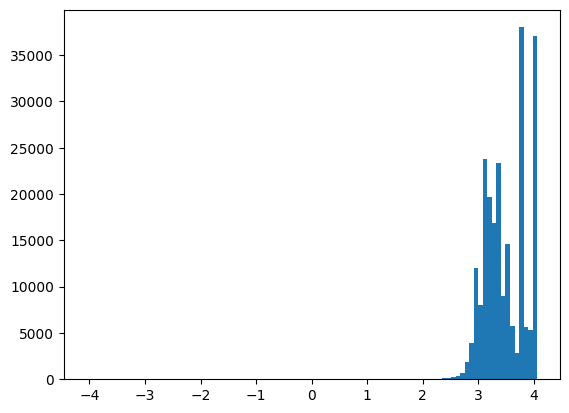

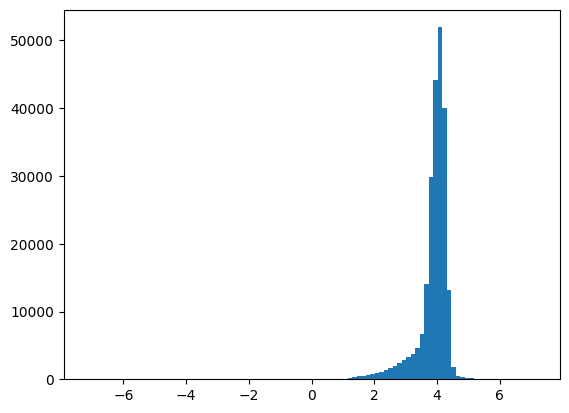

<Figure size 640x480 with 0 Axes>

In [177]:
for i in range(7):
    plt.hist(dataset.data[:,i],bins=100)
    plt.figure()
plt.show()

In [178]:
class Generator(nn.Module):
    def __init__(self):
      super().__init__()
      
      N_z = 20
        
      self.main = nn.Sequential(
        nn.Linear(N_z,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,9),
        nn.ReLU(),
        nn.Linear(9,7)
      )
    def forward(self, input):
      return self.main(input)
      

In [179]:
class Discriminator(nn.Module):
    def __init__(self):
      super().__init__()
        
      self.main = nn.Sequential(
        nn.Linear(7,25),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.Linear(25,10),
        nn.ReLU(),
        nn.Linear(10,1),
        nn.Sigmoid()
      )
    def forward(self, input):
      return self.main(input)
    

In [180]:
mps_device = torch.device('mps')

net_G = Generator().to(mps_device)
net_D = Discriminator().to(mps_device)

print(net_G,net_D)

Generator(
  (main): Sequential(
    (0): Linear(in_features=20, out_features=25, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=25, out_features=25, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=25, out_features=25, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=25, out_features=9, bias=True)
    (10): ReLU()
    (11): Linear(in_features=9, out_features=7, bias=True)
  )
) Discriminator(
  (main): Sequential(
    (0): Linear(in_features=7, out_features=25, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=25, out_features=25, bias=True)
    (4): ReLU()
    (5): Linear(in_features=25, out_features=10, bias=

In [181]:
N_z = 20
noise = torch.randn(256, N_z, device = mps_device)
real_label = 1
fake_label = 0
optimizer_G = optim.Adam(net_G.parameters(), lr = 0.0001, betas= (0.5,0.999))
optimizer_D = optim.Adam(net_D.parameters(), lr = 0.0001, betas= (0.5,0.999))

In [182]:
# Lists to keep track of progress

G_losses = []
D_losses = []
iters = 0
num_epochs = 100
net_G.to(mps_device)
net_G.apply(weights_init)
net_D.apply(weights_init)

print("Starting Training Loop...")

for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):

    avg_error_G, avg_error_D = 0, 0
    avg_Dx, avg_DGz1, avg_DGz2 = 0., 0., 0.

    for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):

        # Update the discriminator network

        ## Train with all-real batch
        net_D.zero_grad()
        
        real_data = data.to(mps_device)
        b_size = len(data)
        
        output = net_D(real_data).view(-1)

        err_D_real = -torch.mean(output)
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, N_z, device=mps_device)
        fake_p = net_G(noise)

        output = net_D(fake_p.detach()).view(-1)

        err_D_fake = torch.mean(output)
        
        err_D = err_D_real + err_D_fake
        err_D.backward()

        # update the discriminator network
        optimizer_D.step()

        # Update the Generator network: maximize log(D(G(z)))
        net_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        output = net_D(fake_p).view(-1)
        err_G = -torch.mean(output)
        err_G.backward()
        
        #for name, param in net_G.named_parameters():
        #    print(name, param)
        #    continue
        
        # update the generator network
        optimizer_G.step()
        
        # computing the average losses and discriminator
        avg_error_G += err_G.item()
        avg_error_D += err_D.item()

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_G(noise).detach().cpu()
            # plot correlations of x-y E-t r-theta

        iters += 1

    avg_error_G = avg_error_G/len(dataloader.dataset)
    avg_error_D = avg_error_D/len(dataloader.dataset)
    if len(G_losses)>0:
        if avg_error_G<G_losses[-1]:
            torch.save(net_G.state_dict(), 'saved_Gen.pt')
    G_losses.append(avg_error_G)
    D_losses.append(avg_error_D)
    print(f'{epoch}/{num_epochs}\tLoss_D: {avg_error_D:.4f}\tLoss_G: {avg_error_G:.4f}')

initialized
initialized
initialized
initialized
initialized
initialized
initialized
initialized
initialized
Starting Training Loop...


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/1915898212.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):


 epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/1915898212.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

0/100	Loss_D: 0.0087	Loss_G: 0.0317


 batch: 0it [00:00, ?it/s]

1/100	Loss_D: 0.0012	Loss_G: 0.0661


 batch: 0it [00:00, ?it/s]

2/100	Loss_D: 0.0062	Loss_G: 0.0616


 batch: 0it [00:00, ?it/s]

3/100	Loss_D: 0.0094	Loss_G: 0.0387


 batch: 0it [00:00, ?it/s]

4/100	Loss_D: 0.0143	Loss_G: 0.0267


 batch: 0it [00:00, ?it/s]

5/100	Loss_D: 0.0190	Loss_G: 0.0167


 batch: 0it [00:00, ?it/s]

6/100	Loss_D: 0.0188	Loss_G: 0.0145


 batch: 0it [00:00, ?it/s]

7/100	Loss_D: 0.0153	Loss_G: 0.0195


 batch: 0it [00:00, ?it/s]

8/100	Loss_D: 0.0185	Loss_G: 0.0153


 batch: 0it [00:00, ?it/s]

9/100	Loss_D: 0.0187	Loss_G: 0.0144


 batch: 0it [00:00, ?it/s]

10/100	Loss_D: 0.0187	Loss_G: 0.0138


 batch: 0it [00:00, ?it/s]

11/100	Loss_D: 0.0208	Loss_G: 0.0123


 batch: 0it [00:00, ?it/s]

12/100	Loss_D: 0.0208	Loss_G: 0.0122


 batch: 0it [00:00, ?it/s]

13/100	Loss_D: 0.0206	Loss_G: 0.0123


 batch: 0it [00:00, ?it/s]

14/100	Loss_D: 0.0206	Loss_G: 0.0127


 batch: 0it [00:00, ?it/s]

15/100	Loss_D: 0.0209	Loss_G: 0.0124


 batch: 0it [00:00, ?it/s]

16/100	Loss_D: 0.0206	Loss_G: 0.0126


 batch: 0it [00:00, ?it/s]

17/100	Loss_D: 0.0201	Loss_G: 0.0130


 batch: 0it [00:00, ?it/s]

18/100	Loss_D: 0.0202	Loss_G: 0.0129


 batch: 0it [00:00, ?it/s]

19/100	Loss_D: 0.0204	Loss_G: 0.0127


 batch: 0it [00:00, ?it/s]

20/100	Loss_D: 0.0198	Loss_G: 0.0133


 batch: 0it [00:00, ?it/s]

21/100	Loss_D: 0.0213	Loss_G: 0.0115


 batch: 0it [00:00, ?it/s]

22/100	Loss_D: 0.0212	Loss_G: 0.0116


 batch: 0it [00:00, ?it/s]

23/100	Loss_D: 0.0212	Loss_G: 0.0112


 batch: 0it [00:00, ?it/s]

24/100	Loss_D: 0.0213	Loss_G: 0.0115


 batch: 0it [00:00, ?it/s]

25/100	Loss_D: 0.0213	Loss_G: 0.0112


 batch: 0it [00:00, ?it/s]

26/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

27/100	Loss_D: 0.0217	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

28/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

29/100	Loss_D: 0.0217	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

30/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

31/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

32/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

33/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

34/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

35/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

36/100	Loss_D: 0.0217	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

37/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

38/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

39/100	Loss_D: 0.0217	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

40/100	Loss_D: 0.0217	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

41/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

42/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

43/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

44/100	Loss_D: 0.0217	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

45/100	Loss_D: 0.0217	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

46/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

47/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

48/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

49/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

50/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

51/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

52/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

53/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

54/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

55/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

56/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

57/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

58/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

59/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

60/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

61/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

62/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

63/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

64/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

65/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

66/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

67/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

68/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

69/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

70/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

71/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

72/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

73/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

74/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

75/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

76/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

77/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

78/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

79/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

80/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

81/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

82/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

83/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

84/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

85/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

86/100	Loss_D: 0.0221	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

87/100	Loss_D: 0.0217	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

88/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

89/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

90/100	Loss_D: 0.0207	Loss_G: 0.0113


 batch: 0it [00:00, ?it/s]

91/100	Loss_D: 0.0114	Loss_G: 0.0192


 batch: 0it [00:00, ?it/s]

92/100	Loss_D: 0.0194	Loss_G: 0.0201


 batch: 0it [00:00, ?it/s]

93/100	Loss_D: 0.0197	Loss_G: 0.0145


 batch: 0it [00:00, ?it/s]

94/100	Loss_D: 0.0215	Loss_G: 0.0117


 batch: 0it [00:00, ?it/s]

95/100	Loss_D: 0.0217	Loss_G: 0.0108


 batch: 0it [00:00, ?it/s]

96/100	Loss_D: 0.0216	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

97/100	Loss_D: 0.0215	Loss_G: 0.0110


 batch: 0it [00:00, ?it/s]

98/100	Loss_D: 0.0217	Loss_G: 0.0109


 batch: 0it [00:00, ?it/s]

99/100	Loss_D: 0.0217	Loss_G: 0.0108


In [183]:
classname = net_G.__class__.__name__
if classname.find('Linear') == -1: print("found")

found


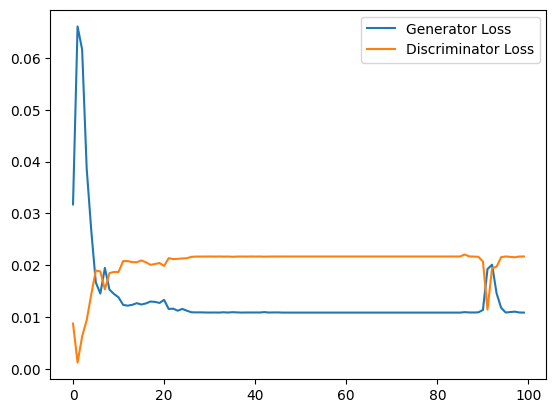

In [184]:
plt.plot(G_losses)
plt.plot(D_losses)

plt.legend(["Generator Loss","Discriminator Loss"])

In [217]:
noise = torch.randn(230247, N_z, device='cpu')
net_G.to('cpu')
fake_p = net_G(noise).detach().numpy()

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_6189/990361329.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


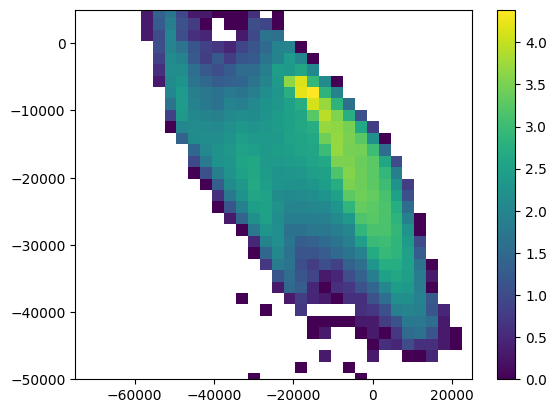

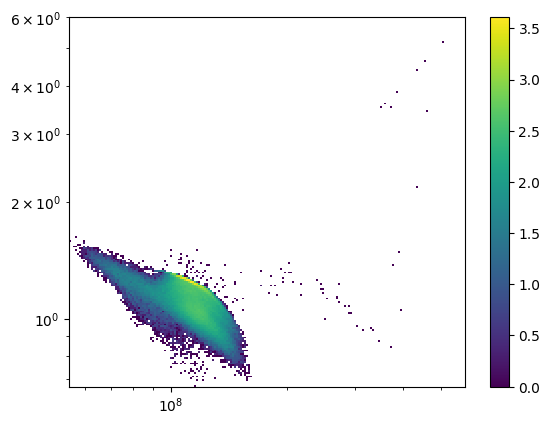

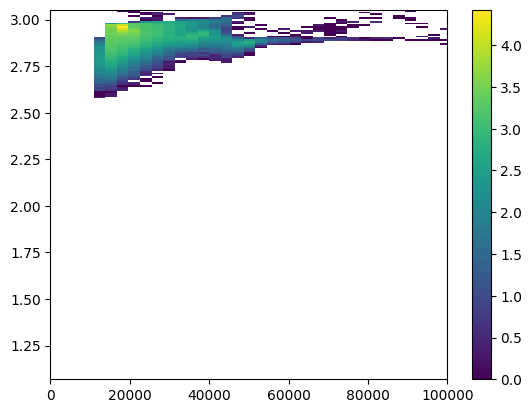

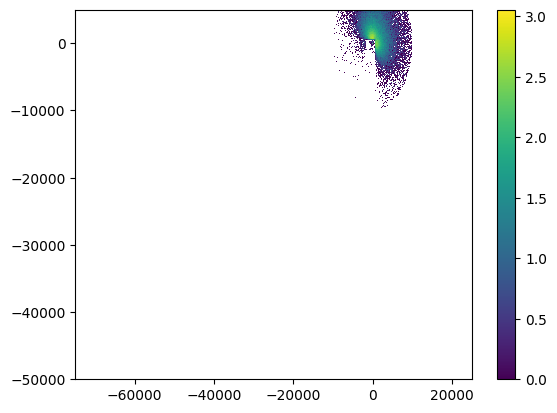

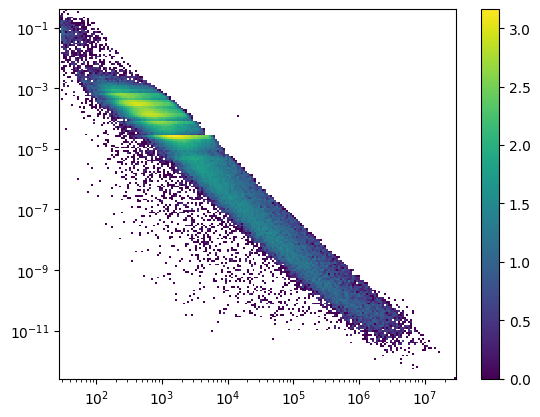

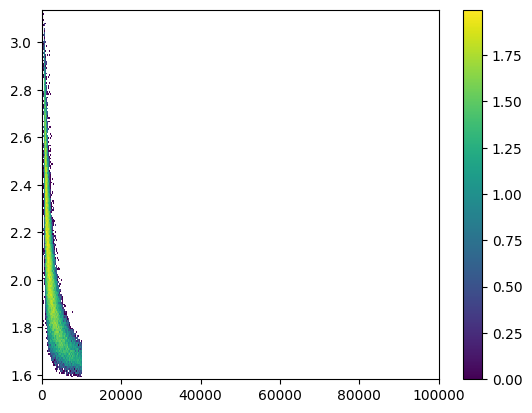

In [218]:
generated_df = df_N.copy()

for i in range(len(param_list)-1):
    mean = dataset.norm.loc[param_list[i]]['min']
    std =  dataset.norm.loc[param_list[i]]['max_min_diff']
    generated_df[param_list[i]]= 1/2*(1-sp.erf(fake_p[:,i]/np.sqrt(2)))
    generated_df[param_list[i]] = fake_p[:,i]*std+mean*np.ones(len(fake_p[:,i]))

generated_df['r']=np.sqrt(generated_df[' xx']**2+generated_df[' yy']**2)
th_g = np.arccos(generated_df[' pzz'].values/np.sqrt(generated_df[' pxx'].values**2+generated_df[' pyy'].values**2+generated_df[' pzz'].values**2))
generated_df['theta']=th_g
plots(generated_df)
plots(df_N)